## Disease Prediction Using Classification

In this notebook, we build a classification model to **predict the disease (prognosis)** based on a patient's symptoms, weather conditions, and other features such as age and gender.

### 🔍 Why Classification?

This task is a classic **supervised learning problem**: we have input features and a known output label (`prognosis`). Classification allows us to train a model that can learn from historical cases and make accurate predictions on new patient data.

For example:
- If a patient presents with **headache, vomiting, and high temperature**, the model may predict a high probability of **Migraine**.
- If a patient has **chest pain, high blood pressure, and humidity is high**, it might predict **Heart Attack**.

These predictions could support **clinical decision-making**, early detection, or patient triage.

### 🔗 How Pattern Mining Helps

Earlier, we used pattern mining (FP-Growth) to identify frequent symptom combinations linked to specific diseases. Those patterns help:
- Highlight **strong symptom-disease associations** (e.g., `{headache, vomiting} → Migraine`)
- Guide **feature importance awareness** before modeling
- Validate whether the model is learning similar relationships

### ❌ Why Not Clustering or Outlier Detection?

- **Clustering** is unsupervised and used to explore hidden groupings — but we already know the disease labels.
- **Outlier detection** identifies rare or unusual data points — useful for anomaly detection, not disease prediction.

Therefore, **classification** is the most appropriate and effective approach for our goal.


## Step 1: Load Preprocessed Data

We begin by loading the cleaned and scaled dataset from the preprocessing step. This dataset includes both binary symptom indicators and continuous features (e.g., age, weather) that have been normalized.


In [48]:
import pandas as pd

# Load preprocessed data
df = pd.read_csv("../data/processed/cleaned_data.csv")

# Separate features and target
X = df.drop(columns=["prognosis"])
y = df["prognosis"]

print(f"Dataset shape: {X.shape}")
print(f"Target classes: {y.nunique()} → {y.unique()[:11]}")
# Display first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(X.head())


Dataset shape: (4981, 49)
Target classes: 11 → ['Heart Attack' 'Influenza' 'Dengue' 'Sinusitis' 'Eczema' 'Common Cold'
 'Heat Stroke' 'Migraine' 'Malaria' 'Arthritis' 'Stroke']

First few rows of the dataset:
        Age  Gender  Temperature (C)  Humidity  Wind Speed (km/h)  nausea  \
0  0.030303       1         0.729691  0.586755           0.264610       1   
1  0.545455       0         0.654889  0.364238           0.486594       0   
2  0.444444       0         0.515404  0.709272           0.136890       0   
3  0.050505       0         0.933323  0.380132           0.575202       1   
4  0.696970       0         0.593129  0.793377           0.572230       0   

   joint_pain  abdominal_pain  high_fever  chills  ...  sinus_headache  \
0           0               0           0       0  ...               0   
1           0               0           0       1  ...               0   
2           0               0           0       0  ...               0   
3           0               0   

## Step 2: Split Data into Training and Test Sets

To evaluate our classification model, we split the data into two parts:

- **Training set**: Used to train the model (80% of the data).
- **Test set**: Used to evaluate how well the model performs on unseen data (20%).

We use `train_test_split()` from `scikit-learn` with the following parameters:

- `X`: All the input features (symptoms, age, weather data, etc.).
- `y`: The target labels (i.e., the `prognosis` column — the disease to be predicted).
- `test_size=0.2`: Allocates 20% of the data for testing.
- `stratify=y`: Ensures that each class (disease) is proportionally represented in both train and test sets.
- `random_state=42`: Ensures reproducibility by fixing the random seed.

This gives us:

- `X_train`: Feature values for training.
- `X_test`: Feature values for testing.
- `y_train`: Target labels for training.
- `y_test`: Target labels for testing.


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


## Step 3: Train a K-Nearest Neighbors (KNN) Classifier

We train a KNN model using `k = 5`, which means the prediction is based on the 5 closest neighbors in the training data. KNN is a distance-based method, so it's important that continuous features are properly scaled — which was done during preprocessing.

### Introduction to K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) is a **non-parametric** and **instance-based** learning algorithm. It works by comparing a new, unseen data point to the labeled data points in the training set. Specifically, it looks for the `k` closest data points (neighbors) in terms of feature similarity — typically using a distance metric like Euclidean distance — and assigns the most common class label among those neighbors to the new point.

This method is effective when similar cases tend to have similar outcomes, making it highly interpretable and intuitive.

In our context, KNN is useful because it can naturally take into account the **similarity of symptoms and environmental conditions** (like temperature or humidity) across patients. For example, if previous patients with high fever, chest pain, and similar weather exposure were diagnosed with dengue, KNN can use those historical patterns to make accurate predictions for new cases. It doesn't assume a fixed model form, which is helpful given the complex, multi-factor nature of medical data.


### 🔍 Visual Explanation of KNN (Illustration Only)

To help visualize how the **K-Nearest Neighbors algorithm** works, the following plot shows a **synthetic 2D dataset** and a new data point being classified based on its 5 nearest neighbors.

> ⚠️ **Note**: This example is **purely illustrative**. It uses **artificial data** for visualization purposes and is not based on the actual medical dataset used in this project.

The plot demonstrates:
- How KNN uses distance to find the `k` nearest points.
- How the predicted class is chosen by **majority vote** among neighbors.
- The visual connection between the new sample and its neighbors.


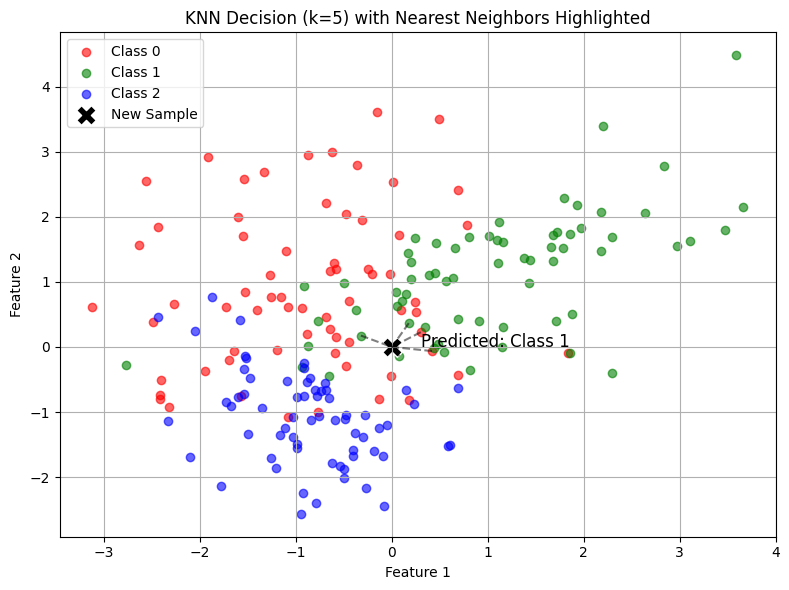

In [50]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import numpy as np

# Generate simple 2D data for demonstration
X, y = make_classification(
    n_samples=200, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, n_classes=3, random_state=42
)

colors = ['red', 'green', 'blue']
class_labels = ['Class 0', 'Class 1', 'Class 2']

# Train KNN model
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X, y)

# New sample
new_point = np.array([[0, 0]])
predicted_class = knn.predict(new_point)[0]

# Find k nearest neighbors
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X)
distances, indices = nn.kneighbors(new_point)

# Plot the data
plt.figure(figsize=(8, 6))

# Plot existing points
for class_value in np.unique(y):
    plt.scatter(
        X[y == class_value, 0], X[y == class_value, 1],
        color=colors[class_value], label=class_labels[class_value], alpha=0.6
    )

# Highlight nearest neighbors
for idx in indices[0]:
    plt.plot([X[idx, 0], new_point[0, 0]], [X[idx, 1], new_point[0, 1]], 
             'k--', alpha=0.5)

# Plot new point
plt.scatter(new_point[0][0], new_point[0][1], color='black', edgecolor='white', 
            marker='X', s=200, label='New Sample')

# Annotate prediction
plt.text(new_point[0][0] + 0.3, new_point[0][1], 
         f"Predicted: Class {predicted_class}", fontsize=12, color='black')

plt.title(f"KNN Decision (k={k}) with Nearest Neighbors Highlighted")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on test set
y_pred = knn.predict(X_test)


## Step 3.1: Evaluate Model Performance

We evaluate the KNN model using standard classification metrics:
- **Accuracy**: Overall correctness
- **Precision / Recall / F1-Score**: Per-class evaluation
- **Confusion Matrix**: Visual breakdown of true vs predicted labels


Accuracy: 0.9679
              precision    recall  f1-score   support

   Arthritis       1.00      0.98      0.99        60
 Common Cold       0.90      0.98      0.94        62
      Dengue       1.00      0.97      0.98        62
      Eczema       1.00      1.00      1.00        62
Heart Attack       0.98      0.98      0.98       194
 Heat Stroke       1.00      0.91      0.95        65
   Influenza       0.92      0.94      0.93       126
     Malaria       1.00      0.98      0.99        64
    Migraine       0.96      0.97      0.96       180
   Sinusitis       1.00      0.97      0.98        60
      Stroke       0.95      0.95      0.95        62

    accuracy                           0.97       997
   macro avg       0.97      0.97      0.97       997
weighted avg       0.97      0.97      0.97       997



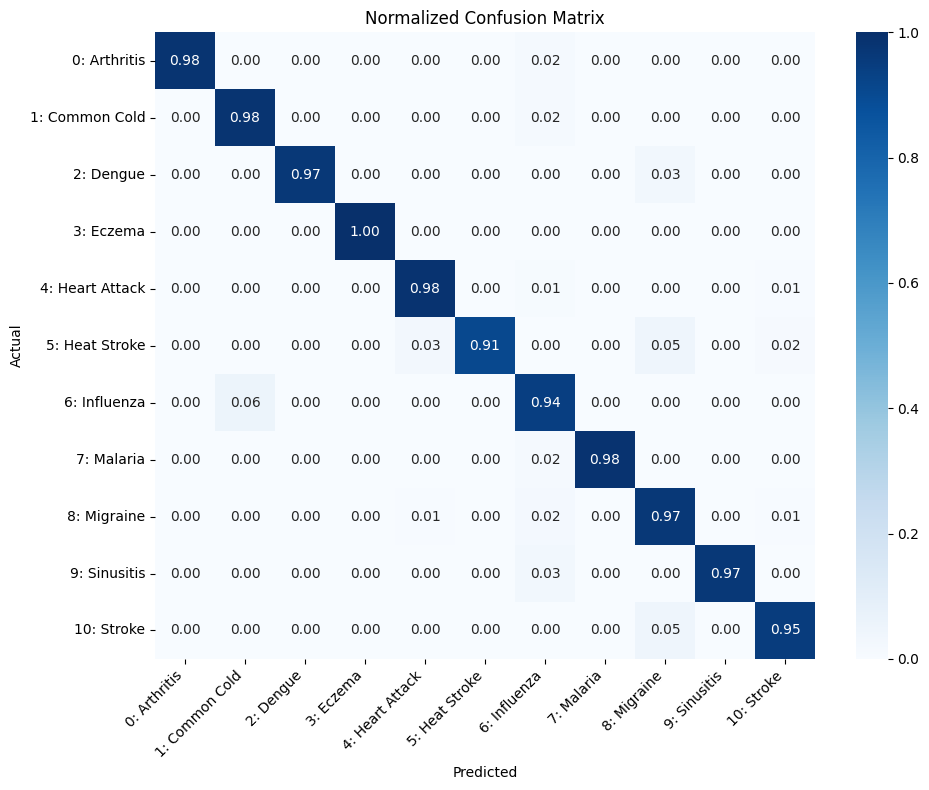

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def evaluate_model(y_true, y_pred, class_names, save_path="../report/confusion_matrix_normalized.png"):
    """
    Evaluates a classification model by printing metrics and plotting a normalized confusion matrix.

    Parameters:
    - y_true: Ground truth labels
    - y_pred: Predicted labels
    - class_names: List of class names in the order of encoded labels
    - save_path: Path to save the confusion matrix image
    """

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Format labels: e.g. 0: Arthritis, 1: Common Cold, ...
    labels = [f"{i}: {name}" for i, name in enumerate(class_names)]

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Ensure output folder exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=True,
                xticklabels=labels, yticklabels=labels)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Get class names from the target variable
# If your dataframe is still called df
class_names = df['prognosis'].unique().tolist()
class_names = sorted(class_names)  # Ensure correct order

# Evaluate the model
save_path = "../report/confusion_matrix_normalized.png"
evaluate_model(y_test, y_pred, class_names, save_path)

## Step 3.2: Optimize the Number of Neighbors (k)

K-Nearest Neighbors relies on the `k` parameter — the number of nearest neighbors used to classify a new point.

Choosing the right `k` is crucial:
- **Too small** → very sensitive to noise (overfitting).
- **Too large** → overly smooth predictions (underfitting).

In this step, we evaluate multiple values of `k` and visualize their corresponding accuracy scores. Our goal is to select the value of `k` that maximizes accuracy on the test set.


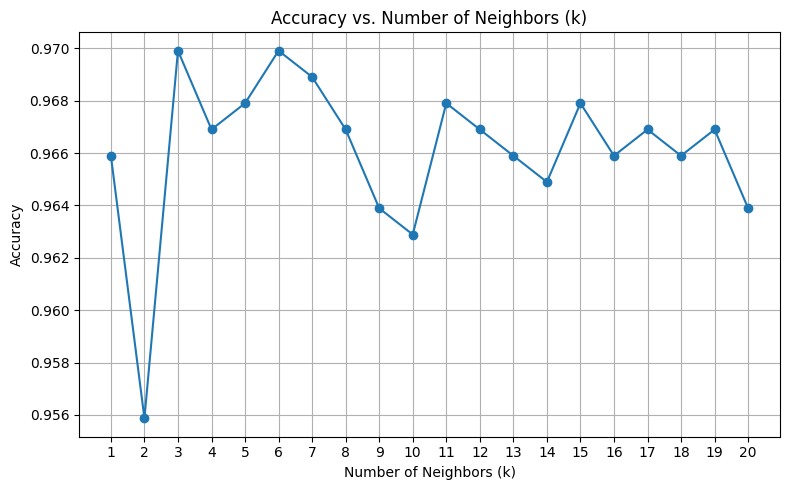

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = range(1, 21)
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred_k = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

# Plot accuracy vs k
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.title("Accuracy vs. Number of Neighbors (k)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig("../report/knn_k_optimization.png", dpi=300)
plt.show()


## Step 3.3: Final KNN Model & Interpretation

After tuning the `k` value, we retrain the model using the **best-performing number of neighbors** and finalize our results.

We evaluate this model again to confirm its performance and summarize the key takeaways.


✅ Final KNN model trained with k = 3

Final Classification Report:
              precision    recall  f1-score   support

   Arthritis       1.00      0.98      0.99        60
 Common Cold       0.88      0.98      0.93        62
      Dengue       0.98      0.97      0.98        62
      Eczema       1.00      1.00      1.00        62
Heart Attack       0.99      0.99      0.99       194
 Heat Stroke       0.97      0.94      0.95        65
   Influenza       0.94      0.93      0.94       126
     Malaria       0.98      0.98      0.98        64
    Migraine       0.96      0.98      0.97       180
   Sinusitis       1.00      0.97      0.98        60
      Stroke       0.97      0.94      0.95        62

    accuracy                           0.97       997
   macro avg       0.97      0.97      0.97       997
weighted avg       0.97      0.97      0.97       997

Accuracy: 0.9699
              precision    recall  f1-score   support

   Arthritis       1.00      0.98      0.99     

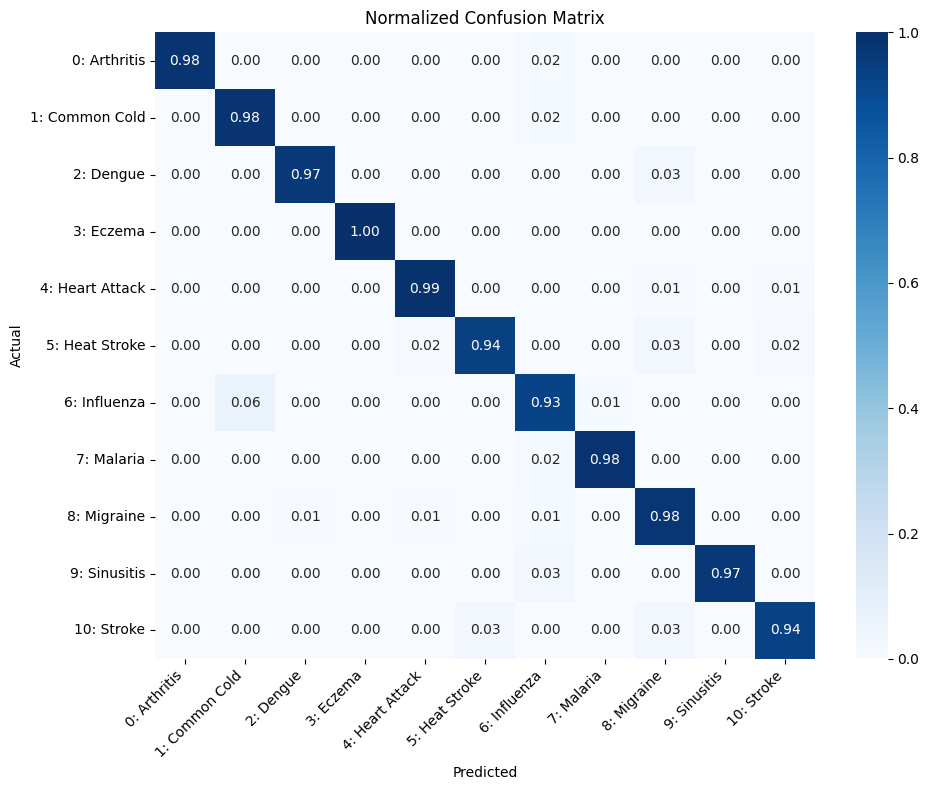

In [59]:
# Final model with best k (replace with your chosen best_k)
best_k = k_values[accuracies.index(max(accuracies))]
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)
final_preds = final_knn.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print(f"✅ Final KNN model trained with k = {best_k}")
print("\nFinal Classification Report:")
print(classification_report(y_test, final_preds))

# Generate new confusion matrix
evaluate_model(y_test, final_preds, class_names, save_path="../report/final_confusion_matrix.png")



## Step 4: Disease Prediction Using Decision Tree Classifier

In this step, we train a **Decision Tree classifier** to predict patient diagnoses based on their symptoms and environmental conditions.

### What is a Decision Tree?

A **Decision Tree** is a supervised learning model that makes predictions by learning a series of **if-else rules** from the data. The model recursively splits the dataset based on feature values that best separate the classes. The resulting structure is a flowchart-like tree, where:

- **Internal nodes** represent decisions based on feature thresholds (e.g., "Is temperature > 38°C?").
- **Branches** represent possible outcomes of a decision.
- **Leaf nodes** represent the final predicted class (diagnosis).

This model is highly interpretable — clinicians can trace back the reasoning behind each prediction by following the tree path.

### Why Use a Decision Tree Here?

In our context, Decision Trees are a good fit because:

- They can naturally handle both **binary symptoms** and **continuous weather features**.
- They can capture **nonlinear interactions** between symptoms and conditions.
- The tree structure provides an **explainable model**, which is desirable in healthcare applications.
- They allow us to identify which features (symptoms, age, weather) are most important for predicting each disease.

### Workflow

We will:
1. Train a Decision Tree model on our dataset.
2. Evaluate its predictive performance.
3. Visualize the learned tree structure to inspect how the model makes decisions.
4. Compare its performance.

### Limitations of Decision Trees

While Decision Trees offer excellent interpretability, they also come with some limitations:

- **Overfitting**: A fully grown tree may fit the training data perfectly but perform poorly on new data. Pruning or limiting the tree depth (e.g., `max_depth`) is often required to avoid this.
- **Instability**: Small changes in the data can lead to very different tree structures, as the tree-building process is greedy.
- **Bias toward features with more levels**: Features with more unique values may dominate splits, even if they are not truly more informative.
- **Lower predictive power** compared to ensemble methods (such as Random Forest or Gradient Boosted Trees), which combine multiple trees to improve accuracy and robustness.

Despite these limitations, Decision Trees remain a valuable tool for **interpretable baseline models** and for understanding the structure of the data.



## Step 4.1: Train the Decision Tree Classifier

We first initialize and train a **Decision Tree classifier** using the training set.

At this stage, we use default hyperparameters, meaning the tree will grow fully to fit the data. We will later explore how controlling the tree depth can help improve generalization.

Training a Decision Tree involves the model learning **splitting rules** that divide the feature space into regions associated with each disease class.

We then generate predictions on the test set to evaluate the model's performance.


In [63]:
from sklearn.tree import DecisionTreeClassifier

# Initialize Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on test set
dt_pred = dt_model.predict(X_test)


## Step 4.2: Evaluate the Decision Tree Model

We evaluate the Decision Tree classifier using the following metrics:

- **Accuracy**: Overall proportion of correct predictions.
- **Precision / Recall / F1-Score**: Detailed per-class evaluation of model performance.
- **Confusion Matrix**: Visual breakdown of true vs. predicted labels.

These metrics help us understand how well the model performs across different disease classes and whether it tends to favor certain predictions.


Accuracy: 0.9719
              precision    recall  f1-score   support

   Arthritis       0.98      0.98      0.98        60
 Common Cold       0.90      0.92      0.91        62
      Dengue       0.97      0.97      0.97        62
      Eczema       1.00      1.00      1.00        62
Heart Attack       0.99      0.98      0.99       194
 Heat Stroke       0.97      0.97      0.97        65
   Influenza       0.95      0.98      0.96       126
     Malaria       0.97      0.92      0.94        64
    Migraine       0.98      0.98      0.98       180
   Sinusitis       1.00      1.00      1.00        60
      Stroke       0.95      0.94      0.94        62

    accuracy                           0.97       997
   macro avg       0.97      0.97      0.97       997
weighted avg       0.97      0.97      0.97       997



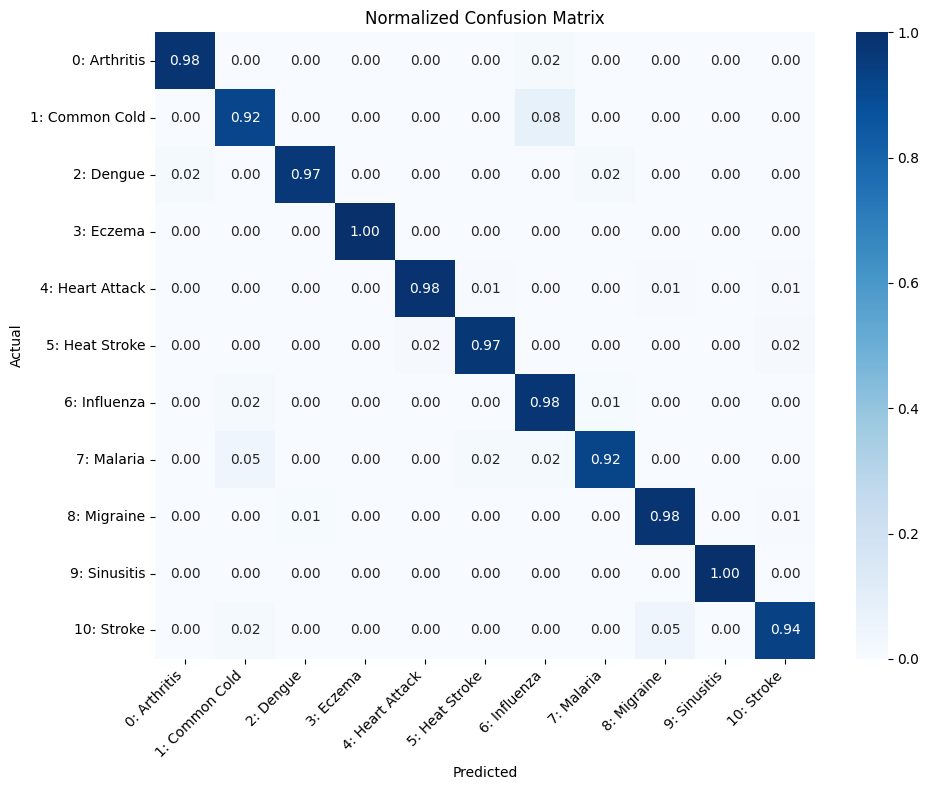

In [64]:
# Use correct class names from your dataframe
class_names = sorted(df['prognosis'].unique().tolist())

# Evaluate Decision Tree
save_path = "../report/decision_tree_confusion_matrix_normalized.png"
evaluate_model(y_test, dt_pred, class_names, save_path)


### SVM

In [60]:
from sklearn.svm import SVC

svm_model = SVC(kernel="rbf", C=1.0, gamma="scale", decision_function_shape="ovr", random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [61]:

# Predict on test set
y_pred = svm_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9840


In [62]:
y_pred = svm_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)